<a href="https://colab.research.google.com/github/antonellagambarte/vision-por-computadoras-II/blob/car_baseline_2/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de enfermedades en plantas usando Visión por Computadora y Aprendizaje Profundo

En esta primera etapa seleccionamos un modelo preentrenado en ImageNet del stack de [Models and pre-trained weights](https://https://docs.pytorch.org/vision/0.12/models.html) de pytorch.
El modelo preentrenado elegido fue [MobileNetV2](https://arxiv.org/abs/1801.04381), ya que creemos que esta solución podría resultar útil en aplicaciones móviles.

In [1]:
test_execution = False

### Imports

In [2]:
import gdown
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import random
import cv2
import numpy as np
import hashlib
import torch
import torchvision
from torchvision import transforms, datasets, models
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
import time
import torchsummary
from torchsummary import summary

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### Carga del dataset

In [3]:
url = "https://drive.google.com/uc?id=1EAe3-k6Mj6UBd3uEA3gtotnSxtIIEkri"
output = "archivo.zip"
destino = "datos_zip"

def zip_is_valid(path):
    if not os.path.isfile(path) or os.path.getsize(path) == 0:
        return False
    try:
        with zipfile.ZipFile(path, 'r') as z:
            return z.testzip() is None
    except Exception as e:
        print("Error:", e)
        return False

# descargar sólo si no existe o si el zip es inválido
if not zip_is_valid(output):
    print("Descargando...")
    gdown.download(url, output, quiet=False, fuzzy=True)
else:
    print(f"'{output}' ya existe.")

os.makedirs(destino, exist_ok=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(destino)

print("Archivo extraído correctamente en :", destino)

'archivo.zip' ya existe.
Archivo extraído correctamente en : datos_zip


### Data transform

Aplicamos transformaciones mínimas.

Valores para normalización y tamaño de imagen (Fuente: [Pytorch doc](https://docs.pytorch.org/vision/0.12/models.html))



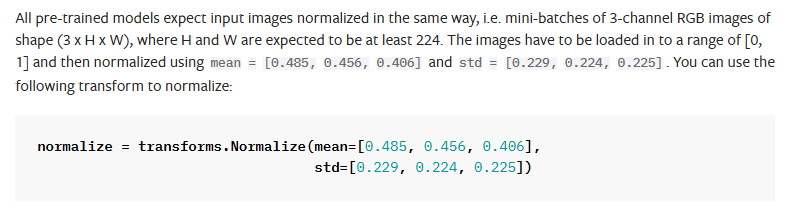

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
])

### Configuración para pruebas con dataset acotado (`test_execution = True`) o train con el dataset completo (`test_execution = False`)

In [5]:
def stratified_split_indices(indices, labels, train_frac=0.8, val_frac=0.1, test_frac=0.1, rng=None):
    if rng is None:
        rng = np.random.RandomState(0)
    train_idxs, val_idxs, test_idxs = [], [], []

    # agrupar por clase y partir cada grupo según fracciones
    class_to_idxs = {}
    for i in indices:
        class_to_idxs.setdefault(labels[i], []).append(i)

    for cls, idxs in class_to_idxs.items():
        idxs = list(idxs)
        rng.shuffle(idxs)
        n = len(idxs)

        # asumiendo suficientes muestras: calcular por fracción y asignar el resto a test
        n_train = int(train_frac * n)
        n_val = int(val_frac * n)
        n_test = n - n_train - n_val

        train_idxs.extend(idxs[:n_train])
        val_idxs.extend(idxs[n_train:n_train + n_val])
        test_idxs.extend(idxs[n_train + n_val:n_train + n_val + n_test])

    return train_idxs, val_idxs, test_idxs

In [6]:
data_dir = "datos_zip/plantvillage dataset/color"

full_dataset = datasets.ImageFolder(root=data_dir)
labels = [label for _, label in full_dataset.samples]

rng = np.random.RandomState(42)

if test_execution:
  # ------------ Crear subset reducido estratificado -----------------
  subset_indices = []
  reduction_factor = 0.1

  for class_idx in range(len(full_dataset.classes)):
      class_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == class_idx]
      n_samples = max(1, int(len(class_indices) * reduction_factor))
      chosen = rng.choice(class_indices, n_samples, replace=False).tolist()
      subset_indices.extend(chosen)

  # mezclar índices
  rng.shuffle(subset_indices)

  # ------------ Partición train / val / test (80% / 10% / 10%) -----------------
  train_indices, val_indices, test_indices = stratified_split_indices(
      subset_indices, labels, train_frac=0.8, val_frac=0.1, test_frac=0.1, rng=rng
  )

  # Crear datasets con transform aplicado
  train_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=train_transform), train_indices)
  val_dataset   = Subset(datasets.ImageFolder(root=data_dir, transform=val_transform), val_indices)
  test_dataset  = Subset(datasets.ImageFolder(root=data_dir, transform=test_transform), test_indices)
else:
  # Segmentación de datos en 3 particiones: 80% train, 10% val, 10% test
  # estratificado sobre todo el dataset
  all_indices = list(range(len(full_dataset)))
  train_indices, val_indices, test_indices = stratified_split_indices(
      all_indices, labels, train_frac=0.8, val_frac=0.1, test_frac=0.1, rng=rng
  )

  train_dataset = Subset(full_dataset, train_indices)
  val_dataset   = Subset(full_dataset, val_indices)
  test_dataset  = Subset(full_dataset, test_indices)

  train_dataset.dataset.transform = train_transform
  val_dataset.dataset.transform = val_transform
  test_dataset.dataset.transform = test_transform

### Selección e instanciación del modelo preentrenado

In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
print(models.list_models())

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

Pesos disponibles para mobilenet v2 ([Link fuente](https://docs.pytorch.org/vision/main/models.html)):

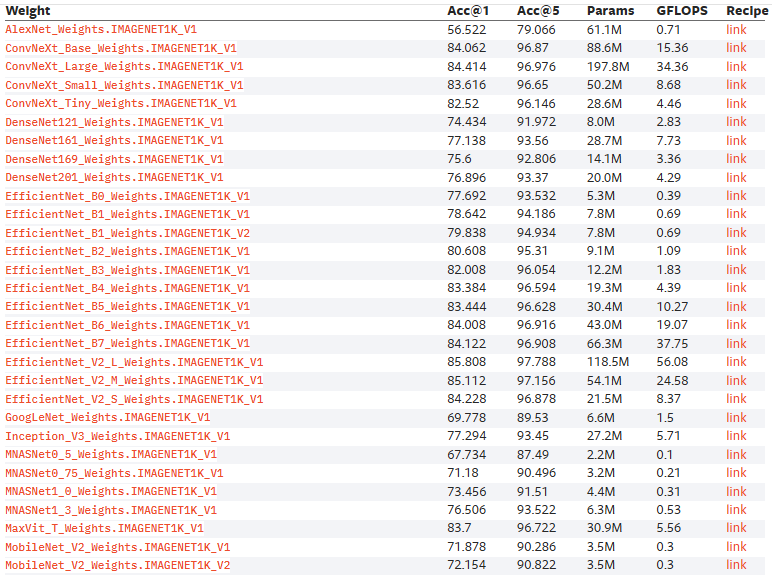

In [9]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Congelamos el feature extractor (model.features) para mantener los pesos aprendidos del modelo preentrenado en ImageNet.
# De este modo solo entrenamos la nueva capa clasificadora
for param in model.parameters():
    param.requires_grad = False


Agregamos dropout y una capa lineal que forman el nuevo cabezal de clasificación del modelo. La capa lineal transforma las características extraídas por el modelo preentrenado en las 38 clases de enfermedades de plantas, permitiendo al modelo aprender a mapear esas características a las nuevas categorías.

In [10]:
num_classes = 38
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, num_classes)
)


Uso de una función de pérdida estándar y el optimizador más básico.

CrossEntropyLoss sirve para este problema debido a que tenemos 38 clases.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Visualización de la red

In [43]:
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

#### Visualización de algunas activaciones

La red, en esta etapa, está viendo:

* Bordes
* Contornos de la hoja
* Texturas internas (nervaduras, manchas, patrones locales)
* Brillo / sombra / forma global
* Separación objeto–fondo

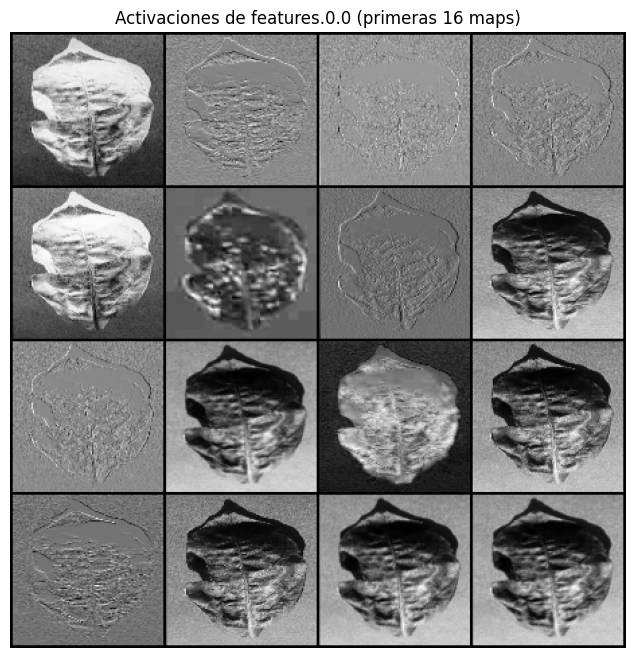

In [58]:
# Visualización de activaciones
target_layer = None
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        target_layer = module
        target_name = name
        break

if target_layer is None:
    raise RuntimeError("No se encontró Conv2d en el modelo.")

# hook para capturar activación
activation = {}
def hook_fn(module, inp, out):
    activation['out'] = out.detach().cpu()

hook = target_layer.register_forward_hook(hook_fn)

# pasar 1 batch
batch = next(iter(train_loader))
x, _ = batch
x1 = x[:1].to(next(model.parameters()).device)

model.eval()
with torch.no_grad():
    _ = model(x1)

hook.remove()
act = activation['out'][0]  # [C, H, W]

# normalizar y seleccionar primeras N feature maps
N = min(16, act.shape[0])
grid = vutils.make_grid(act[:N].unsqueeze(1), nrow=4, normalize=True, scale_each=True)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='viridis')
plt.title(f"Activaciones de {target_name} (primeras {N} maps)")
plt.show()


### Entrenamiento

In [40]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

EPOCH = 10

for epoch in range(EPOCH):

    # TRAIN
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = correct / total
    train_accs.append(train_accuracy)

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = correct / total
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Train Acc={train_accuracy:.4f} | Val Loss={avg_val_loss:.4f} | Val Acc={val_accuracy:.4f}")



Epoch 1: Train Loss=0.9430 | Train Acc=0.8089 | Val Loss=0.3855 | Val Acc=0.9251
Epoch 2: Train Loss=0.3724 | Train Acc=0.9218 | Val Loss=0.2555 | Val Acc=0.9459
Epoch 3: Train Loss=0.2819 | Train Acc=0.9354 | Val Loss=0.2184 | Val Acc=0.9466
Epoch 4: Train Loss=0.2405 | Train Acc=0.9427 | Val Loss=0.1851 | Val Acc=0.9564
Epoch 5: Train Loss=0.2134 | Train Acc=0.9476 | Val Loss=0.1665 | Val Acc=0.9594
Epoch 6: Train Loss=0.1980 | Train Acc=0.9493 | Val Loss=0.1511 | Val Acc=0.9616
Epoch 7: Train Loss=0.1843 | Train Acc=0.9528 | Val Loss=0.1425 | Val Acc=0.9653
Epoch 8: Train Loss=0.1767 | Train Acc=0.9537 | Val Loss=0.1404 | Val Acc=0.9636
Epoch 9: Train Loss=0.1671 | Train Acc=0.9561 | Val Loss=0.1298 | Val Acc=0.9682
Epoch 10: Train Loss=0.1603 | Train Acc=0.9568 | Val Loss=0.1279 | Val Acc=0.9651


### Visualización de resultados

Se visualizan las curvas de loss y accuracy para observar la correcta evolución del entrenamiento y detectar overfitting o underfitting.

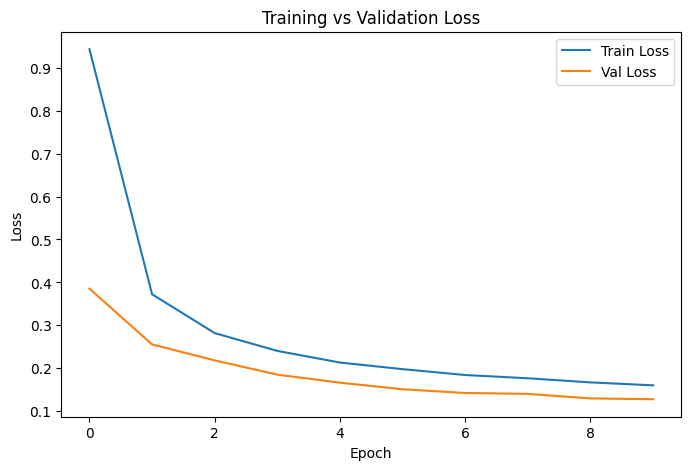

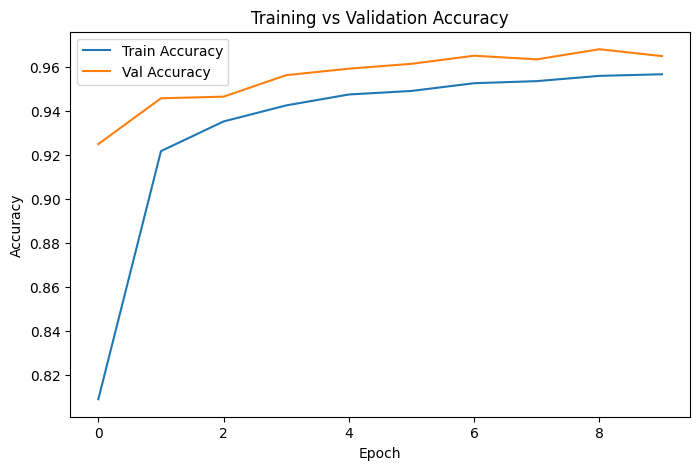

In [41]:
# ---- GRAFICO DE LOSS ----
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# ---- GRAFICO DE ACCURACY ----
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

Visualizamos la matriz de confusión para identificar si hay alguna clase que el modelo esté confundiendo con otra, o si se confunde entre plantas enfermas y sanas.

Se observa una confusión entre:
* `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot` y `Corn_(maize)___Northern_Leaf_Blight`
* `Potato___healthy` y `Soybean___healthy`

De ellas, la confusión más grave es la primera dado que el tratamiento para las distintas enfermedades puede ser distinto.

In [42]:
def create_confusion_matrix(model, dataloader, device):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    return cm, all_labels, all_preds


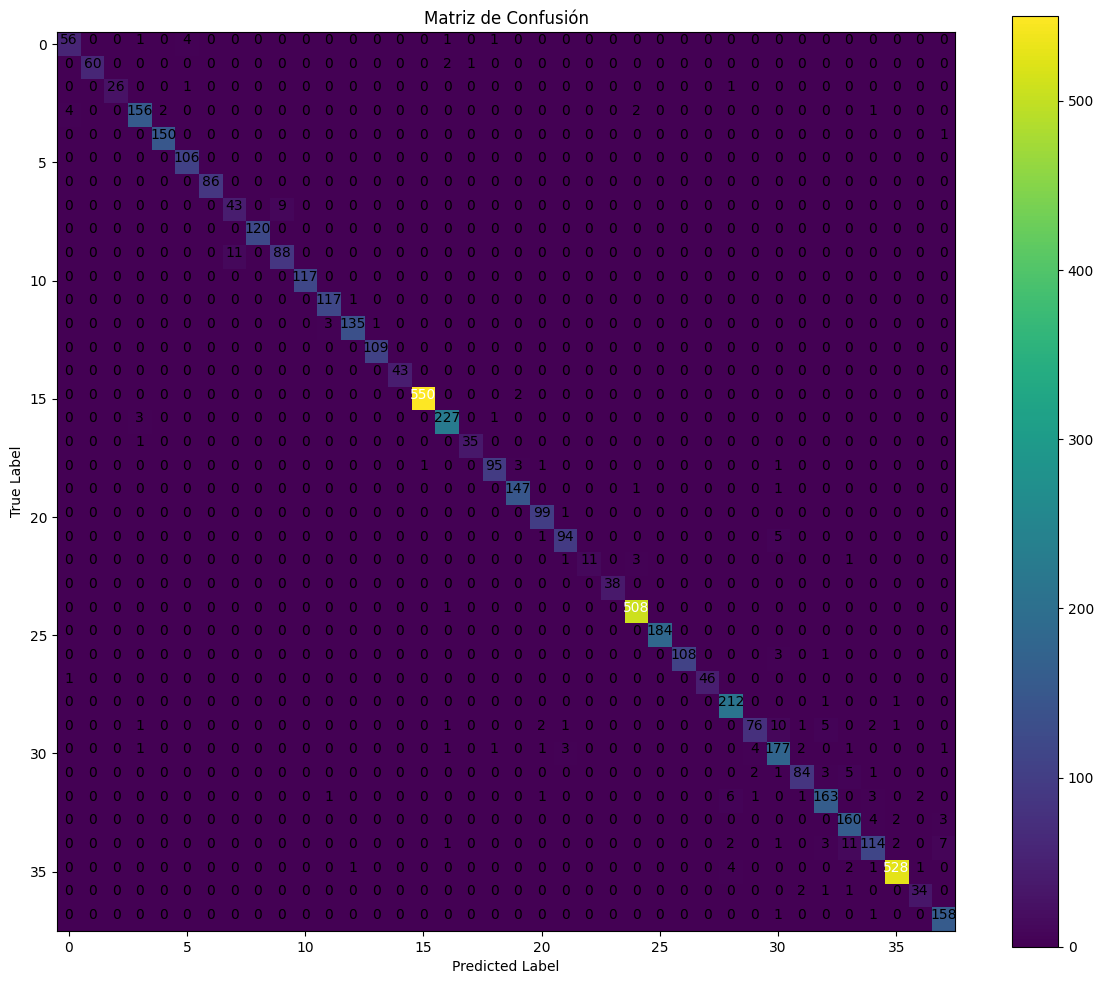

In [43]:
model.eval()

cm, all_labels, all_preds = create_confusion_matrix(model, test_loader, device)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusión")
plt.colorbar()

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


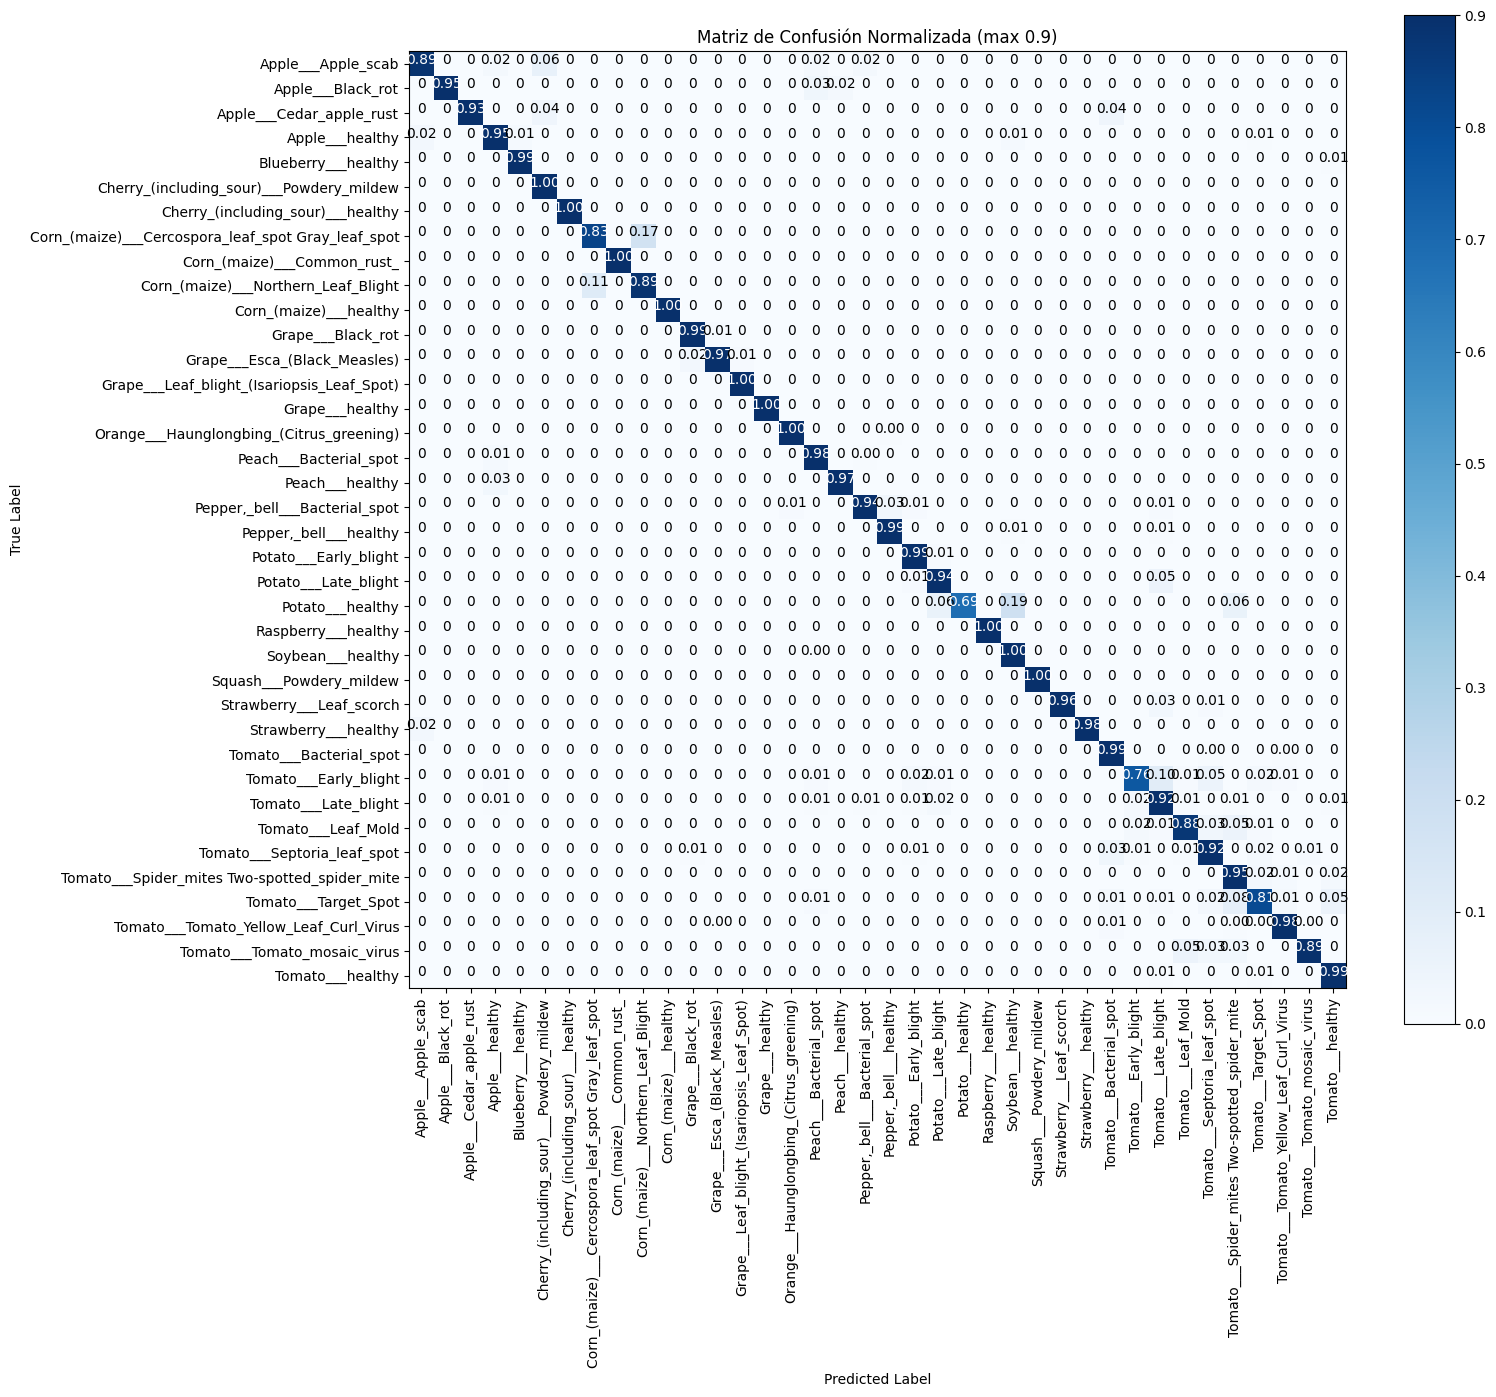

In [44]:
model.eval()

# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 14))
im = plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=0.9)
plt.title("Matriz de Confusión Normalizada (max 0.9)")
plt.colorbar(im)

classes = full_dataset.classes
plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)

# Mostrar números, con "0" si es cero
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        val = cm_normalized[i, j]
        text = "0" if val == 0 else f"{val:.2f}"
        plt.text(j, i, text,
                 horizontalalignment="center",
                 color="white" if val > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



Visualizamos el reporte de clasificación dado que proporciona un resumen detallado de métricas por clase.


In [45]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {overall_accuracy:.4f}\n")

# Generate a classification report
report = classification_report(all_labels, all_preds, target_names=full_dataset.classes, zero_division=0)
print("Classification Report:\n")
print(report)

Overall Accuracy: 0.9635

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.92      0.89      0.90        63
                                 Apple___Black_rot       1.00      0.95      0.98        63
                          Apple___Cedar_apple_rust       1.00      0.93      0.96        28
                                   Apple___healthy       0.96      0.95      0.95       165
                               Blueberry___healthy       0.99      0.99      0.99       151
          Cherry_(including_sour)___Powdery_mildew       0.95      1.00      0.98       106
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.80      0.83      0.81        52
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       120
               Corn_(maize)__

Etiquetas en las que podríamos enfocarnos en mejorar la capacidad del modelo para encontrar todas las instancias de una enfermedad:
* Apple___Apple_scab
* Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
* Potato___healthy
* Tomato___Early_blight
* Tomato___Leaf_Mold
* Tomato___Target_Spot
* Tomato___Tomato_mosaic_virus

Un falso negativo es grave dado que la no detección puede llevar a la propagación de la enfermedad.

Potato___healthy tiene pocas instancias de support dado que, como habíamos visto en el EDA, los ejemplos de estas imágenes son muy pocos en relación a los demás. Esta puede ser la causa de su bajo recall.

